**This notebook shows how to read data from a "zarr" dataset, calculate fog and low clouds frequency, and create timeseries plots.**

Author: Autumn Nguyen and Eli Schwat.
Version: July 2023.

While the original dataset comprises of many raster files, each file representing an image from a single timestamp, the "zarr" dataset is a file that stores data in time series, each timeseries containing all the values of each pixel, or each small group of pixels, at all timestamps that the raster files originally come in.

In [76]:
import xarray as xr

import glob
import os
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import pandas as pd

from dask.distributed import Client, LocalCluster


In [77]:
# Because plot_shoreline.py is in a directory above where this notebook is, we need to import the sys module and add the path to the parent directory to the path list
import sys
sys.path.append('/home/spestana/git/summerfog/')
from plot_shoreline import plot_from_globe_shoreline

In [85]:
def get_four_pixel_values(ds: xr.Dataset, var: str) -> None:

    NE_value = ds.sel(longitude = -123.0, latitude = 48.6, method='nearest')[var].values
    SE_value = ds.sel(longitude = -123.0, latitude = 48.4, method='nearest')[var].values
    SW_value = ds.sel(longitude = -123.15, latitude = 48.4, method='nearest')[var].values
    NW_value = ds.sel(longitude = -123.15, latitude = 48.6, method='nearest')[var].values

    print('FHL (north east): {}'.format(np.round(NE_value,2)))
    print('CP (south east): {}'.format(np.round(SE_value,2)))
    print('FB (south west): {}'.format(np.round(SW_value,2)))
    print('MD (north west): {}'.format(np.round(NW_value,2)))

    return None

In [3]:
bounds = (-125, 46, -122, 49)
shoreline = plot_from_globe_shoreline(bounds)

### Start a Dask Cluster 

In [4]:
# Create a Dask cluster so we can watch the dask dashboard
workers = 6
ip_addres = 'http://j-lundquist-3.ce.washington.edu'
port=':8787'
threads = 2
cluster = LocalCluster(n_workers=workers, threads_per_worker=threads, dashboard_address=port)
client = Client(cluster)

2024-07-12 15:31:19,351 - distributed.diskutils - INFO - Found stale lock file and directory '/home/spestana/dask-worker-space/worker-th5i158y', purging
2024-07-12 15:31:19,352 - distributed.diskutils - INFO - Found stale lock file and directory '/home/spestana/dask-worker-space/worker-le0uj9r1', purging
2024-07-12 15:31:19,352 - distributed.diskutils - INFO - Found stale lock file and directory '/home/spestana/dask-worker-space/worker-yq1gas6x', purging
2024-07-12 15:31:19,352 - distributed.diskutils - INFO - Found stale lock file and directory '/home/spestana/dask-worker-space/worker-uc6dtadq', purging
2024-07-12 15:31:19,353 - distributed.diskutils - INFO - Found stale lock file and directory '/home/spestana/dask-worker-space/worker-lsehqjv7', purging
2024-07-12 15:31:19,353 - distributed.diskutils - INFO - Found stale lock file and directory '/home/spestana/dask-worker-space/worker-z2xul_9x', purging


### Open all raster files from zarr

In [5]:
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    chunks={'time': 40785, 'latitude': 50, 'longitude': 50},
    engine='zarr'
)
# When we pass in a chunks argument, the dataset opened will be filled with Dask arrays

/home/spestana/opt/anaconda3/envs/goesenv/lib/python3.10/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "latitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/spestana/opt/anaconda3/envs/goesenv/lib/python3.10/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [6]:
ds

<xarray.Dataset>
Dimensions:      (time: 40785, latitude: 284, longitude: 284)
Coordinates:
  * latitude     (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude    (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0
  * time         (time) datetime64[ns] 2022-04-30T17:01:17 ... 2022-09-30T16:...
Data variables:
    Height       (time, latitude, longitude) float32 dask.array<chunksize=(40785, 50, 50), meta=np.ndarray>
    spatial_ref  (time) int64 dask.array<chunksize=(40785,), meta=np.ndarray>
    time (UTC)   (time) datetime64[ns] dask.array<chunksize=(40785,), meta=np.ndarray>

In [7]:
bounds = ds.rio.bounds()

In [8]:
ds['Height']

<xarray.DataArray 'Height' (time: 40785, latitude: 284, longitude: 284)>
dask.array<open_dataset-a9135707bdf62626f360c29b23b610efHeight, shape=(40785, 284, 284), dtype=float32, chunksize=(40785, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0
  * time       (time) datetime64[ns] 2022-04-30T17:01:17 ... 2022-09-30T16:51:17
Attributes:
    coordinates:   dem_px_angle_y dem_px_angle_x
    grid_mapping:  spatial_ref

### Get the datetimes from the file names to replace the time index in the dataset
because zarr has a bug that does not allow it to save `datetime64[ns]` objects correctly (precision is lost for hours and minutes)

In [9]:
image_folder = '/storage/GOES/orthorectified/Fog2022_withtime/'
files = glob.glob(os.path.join(image_folder, "*_o.nc"))
files[0] # Take a look at the path of one file

'/storage/GOES/orthorectified/Fog2022_withtime/OR_ABI-L2-ACHAC-M6_G17_s20222440001177_e20222440003550_c20222440007138_o.nc'

In [10]:
datetimes = [
    dt.datetime.strptime(
        f.split('_')[4][1:-1], # parse the start time (the part "s2022__________" in the file name)
        "%Y%j%H%M%S"
    ) for f in files
]
''' The files in zarr are already sorted chronologically, 
but the files in the image_folder directory are not, 
so the datetimes info parsed from the directory also have to be sorted.'''
datetimes = sorted(datetimes)

ds['time'] = datetimes

In [11]:
ds.Height

<xarray.DataArray 'Height' (time: 40785, latitude: 284, longitude: 284)>
dask.array<open_dataset-a9135707bdf62626f360c29b23b610efHeight, shape=(40785, 284, 284), dtype=float32, chunksize=(40785, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0
  * time       (time) datetime64[ns] 2022-05-01T00:01:17 ... 2022-09-30T23:51:17
Attributes:
    coordinates:   dem_px_angle_y dem_px_angle_x
    grid_mapping:  spatial_ref

## Frequency when NaNs are not ignored

### Fog low cloud frequency, with NaNs not ignored but counted as clear sky

We want to compute the frequency (% of time) that there are FLCC in:
* 1 May - 30 Sept 2022 (our whole data record)
* 1 May 14 July 2022 (first half of our data record)
* 15 July - 30 Sept 2022 (second half of our data record)
* on select days (43 in total) with inversions

In [12]:
# For calculating frequency of fog or low cloud cover (FLCC)
ds['FLCC'] = (ds['Height'] < 2000).astype(int) # NaN values return False here (clear skies)

FLCC_freq_1may_30sept = (
    ds['FLCC'].sum(dim='time') / ds['time'].size
)

FLCC_freq_1may_14july = (
    ds.sel(time=slice('2022-05-01','2022-07-14'))['FLCC'].sum(dim='time') / ds.sel(time=slice('2022-05-01','2022-07-14'))['time'].size
)

FLCC_freq_15july_30sept = (
    ds.sel(time=slice('2022-07-15','2022-09-30'))['FLCC'].sum(dim='time') / ds.sel(time=slice('2022-07-15','2022-09-30'))['time'].size
)

# For calculating frequency any cloud cover (CC)
ds['CC'] = (ds['Height'] > 0).astype(int) # NaN values return False here (clear skies)

CC_freq_1may_30sept = (
    ds['CC'].sum(dim='time') / ds['time'].size
)

CC_freq_1may_14july = (
    ds.sel(time=slice('2022-05-01','2022-07-14'))['CC'].sum(dim='time') / ds.sel(time=slice('2022-05-01','2022-07-14'))['time'].size
)

CC_freq_15july_30sept = (
    ds.sel(time=slice('2022-07-15','2022-09-30'))['CC'].sum(dim='time') / ds.sel(time=slice('2022-07-15','2022-09-30'))['time'].size
)

In [13]:
FLCC_freq_1may_30sept.to_netcdf('FLCC_freq_1may_30sept.nc')
FLCC_freq_1may_14july.to_netcdf('FLCC_freq_1may_14july.nc')
FLCC_freq_15july_30sept.to_netcdf('FLCC_freq_15july_30sept.nc')

CC_freq_1may_30sept.to_netcdf('CC_freq_1may_30sept.nc')
CC_freq_1may_14july.to_netcdf('CC_freq_1may_14july.nc')
CC_freq_15july_30sept.to_netcdf('CC_freq_15july_30sept.nc')

In [14]:
# read back in what we just wrote to disk (helps make plotting faster now that our data is no longer "lazily loaded")
FLCC_freq_1may_30sept = xr.open_dataset('FLCC_freq_1may_30sept.nc')
FLCC_freq_1may_14july = xr.open_dataset('FLCC_freq_1may_14july.nc')
FLCC_freq_15july_30sept = xr.open_dataset('FLCC_freq_15july_30sept.nc')

CC_freq_1may_30sept = xr.open_dataset('CC_freq_1may_30sept.nc')
CC_freq_1may_14july = xr.open_dataset('CC_freq_1may_14july.nc')
CC_freq_15july_30sept = xr.open_dataset('CC_freq_15july_30sept.nc')

FLCC_freq_1may_30sept:
FHL (north east): 0.13
CP (south east): 0.33
FB (south west): 0.4
MD (north west): 0.39
FLCC_freq_1may_14july:
FHL (north east): 0.12
CP (south east): 0.22
FB (south west): 0.27
MD (north west): 0.27
FLCC_freq_15july_30sept:
FHL (north east): 0.15
CP (south east): 0.45
FB (south west): 0.53
MD (north west): 0.52


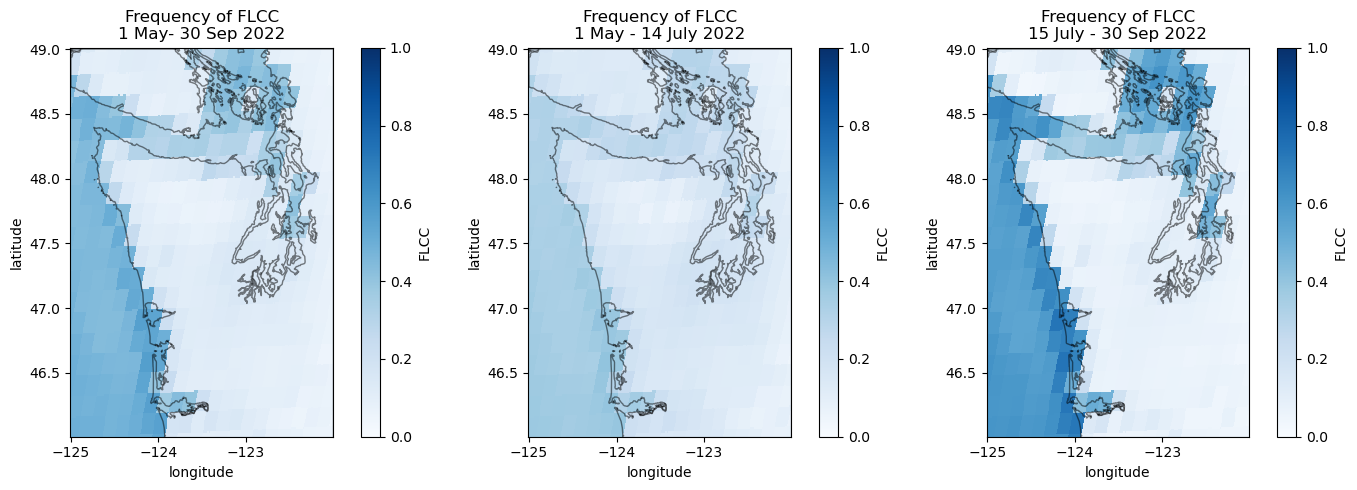

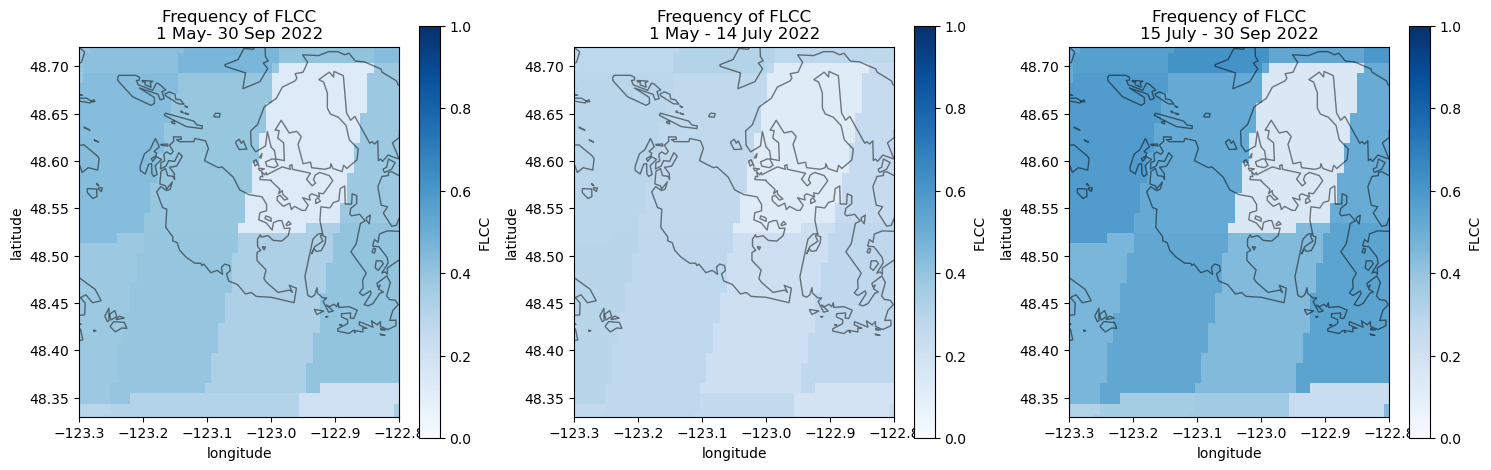

In [92]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5), tight_layout=True)

FLCC_freq_1may_30sept.FLCC.plot(ax = ax1, cmap = 'Blues', vmin=0, vmax=1)
FLCC_freq_1may_14july.FLCC.plot(ax = ax2, cmap = 'Blues', vmin=0, vmax=1)
FLCC_freq_15july_30sept.FLCC.plot(ax = ax3, cmap = 'Blues', vmin=0, vmax=1)
for this_ax in [ax1, ax2, ax3]:
    shoreline.plot(ax=this_ax, edgecolor = "black", color='none', alpha = 0.5, zorder=99)
ax1.set_title('Frequency of FLCC\n1 May- 30 Sep 2022')
ax2.set_title('Frequency of FLCC\n1 May - 14 July 2022')
ax3.set_title('Frequency of FLCC\n15 July - 30 Sep 2022')
plt.savefig('flcc_frequency_maps.jpg', dpi=300)



fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5), tight_layout=True)

FLCC_freq_1may_30sept.FLCC.plot(ax = ax1, cmap = 'Blues', vmin=0, vmax=1)
FLCC_freq_1may_14july.FLCC.plot(ax = ax2, cmap = 'Blues', vmin=0, vmax=1)
FLCC_freq_15july_30sept.FLCC.plot(ax = ax3, cmap = 'Blues', vmin=0, vmax=1)
for this_ax in [ax1, ax2, ax3]:
    shoreline.plot(ax=this_ax, edgecolor = "black", color='none', alpha = 0.5, zorder=99)
ax1.set_title('Frequency of FLCC\n1 May- 30 Sep 2022')
ax2.set_title('Frequency of FLCC\n1 May - 14 July 2022')
ax3.set_title('Frequency of FLCC\n15 July - 30 Sep 2022')
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_ylim([48.33, 48.72])
    this_ax.set_xlim([-123.3, -122.8])
plt.savefig('flcc_frequency_maps_zoom.jpg', dpi=300)

print('FLCC_freq_1may_30sept:')
get_four_pixel_values(FLCC_freq_1may_30sept, 'FLCC')
print('FLCC_freq_1may_14july:')
get_four_pixel_values(FLCC_freq_1may_14july, 'FLCC')
print('FLCC_freq_15july_30sept:')
get_four_pixel_values(FLCC_freq_15july_30sept, 'FLCC')

CC_freq_1may_30sept:
FHL (north east): 0.65
CP (south east): 0.85
FB (south west): 0.93
MD (north west): 0.9
CC_freq_1may_14july:
FHL (north east): 0.8
CP (south east): 0.9
FB (south west): 0.95
MD (north west): 0.95
CC_freq_15july_30sept:
FHL (north east): 0.48
CP (south east): 0.8
FB (south west): 0.9
MD (north west): 0.85


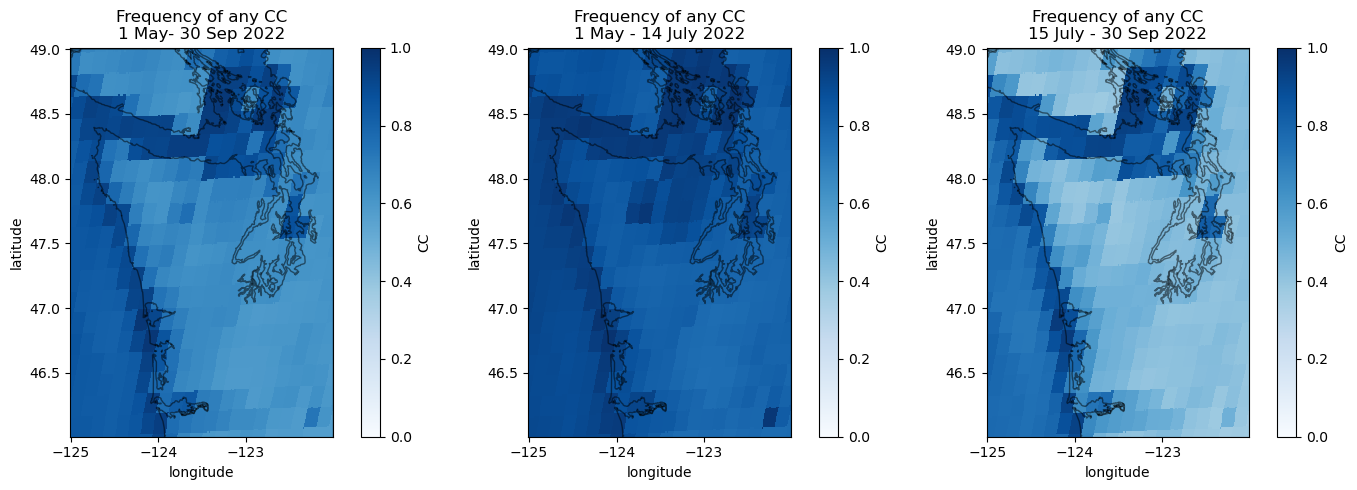

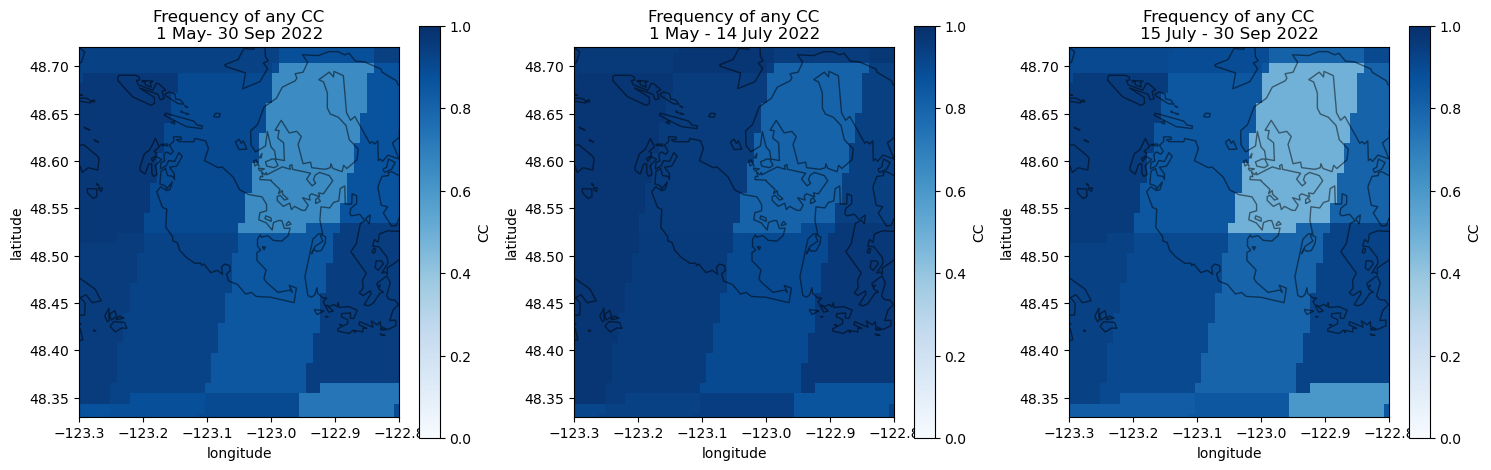

In [87]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5), tight_layout=True)

CC_freq_1may_30sept.CC.plot(ax = ax1, cmap = 'Blues', vmin=0, vmax=1)
CC_freq_1may_14july.CC.plot(ax = ax2, cmap = 'Blues', vmin=0, vmax=1)
CC_freq_15july_30sept.CC.plot(ax = ax3, cmap = 'Blues', vmin=0, vmax=1)
for this_ax in [ax1, ax2, ax3]:
    shoreline.plot(ax=this_ax, edgecolor = "black", color='none', alpha = 0.5, zorder=99)
ax1.set_title('Frequency of any CC\n1 May- 30 Sep 2022')
ax2.set_title('Frequency of any CC\n1 May - 14 July 2022')
ax3.set_title('Frequency of any CC\n15 July - 30 Sep 2022')
plt.savefig('cc_frequency_maps.jpg', dpi=300)


fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5), tight_layout=True)

CC_freq_1may_30sept.CC.plot(ax = ax1, cmap = 'Blues', vmin=0, vmax=1)
CC_freq_1may_14july.CC.plot(ax = ax2, cmap = 'Blues', vmin=0, vmax=1)
CC_freq_15july_30sept.CC.plot(ax = ax3, cmap = 'Blues', vmin=0, vmax=1)
for this_ax in [ax1, ax2, ax3]:
    shoreline.plot(ax=this_ax, edgecolor = "black", color='none', alpha = 0.5, zorder=99)
ax1.set_title('Frequency of any CC\n1 May- 30 Sep 2022')
ax2.set_title('Frequency of any CC\n1 May - 14 July 2022')
ax3.set_title('Frequency of any CC\n15 July - 30 Sep 2022')
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_ylim([48.33, 48.72])
    this_ax.set_xlim([-123.3, -122.8])
plt.savefig('cc_frequency_maps_zoom.jpg', dpi=300)

print('CC_freq_1may_30sept:')
get_four_pixel_values(CC_freq_1may_30sept, 'CC')
print('CC_freq_1may_14july:')
get_four_pixel_values(CC_freq_1may_14july, 'CC')
print('CC_freq_15july_30sept:')
get_four_pixel_values(CC_freq_15july_30sept, 'CC')

Read in inversion days file to look at GOES FLCC on inversion days only

In [17]:
df = pd.read_csv('/home/spestana/git/summerfog/goes/SJI_strongInv2022.txt', skiprows=1, names=['date'])
df['date'] = pd.to_datetime(df.date, format='%Y%m%d')

We have to do some datetime, DatetimeIndex, and datetime64 wrangling here

In [18]:
ds['day'] = pd.DatetimeIndex(ds.time.dt.date.values)

In [19]:
da_FLCC_inversion_days = ds.FLCC[np.isin(pd.DatetimeIndex(ds.time.dt.date.values),df.date.values),:,:]
da_CC_inversion_days = ds.CC[np.isin(pd.DatetimeIndex(ds.time.dt.date.values),df.date.values),:,:]

/home/spestana/opt/anaconda3/envs/goesenv/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [20]:
FLCC_freq_inversion_days = (
    da_FLCC_inversion_days.sum(dim='time') / da_FLCC_inversion_days['time'].size
)

CC_freq_inversion_days = (
    da_CC_inversion_days.sum(dim='time') / da_CC_inversion_days['time'].size
)

In [21]:
FLCC_freq_inversion_days.to_netcdf('FLCC_freq_inversion_days.nc')

CC_freq_inversion_days.to_netcdf('CC_freq_inversion_days.nc')

In [22]:
FLCC_freq_inversion_days = xr.open_dataset('FLCC_freq_inversion_days.nc')

CC_freq_inversion_days = xr.open_dataset('CC_freq_inversion_days.nc')

FHL (north east): 0.12
CP (south east): 0.49
FB (south west): 0.56
MD (north west): 0.58


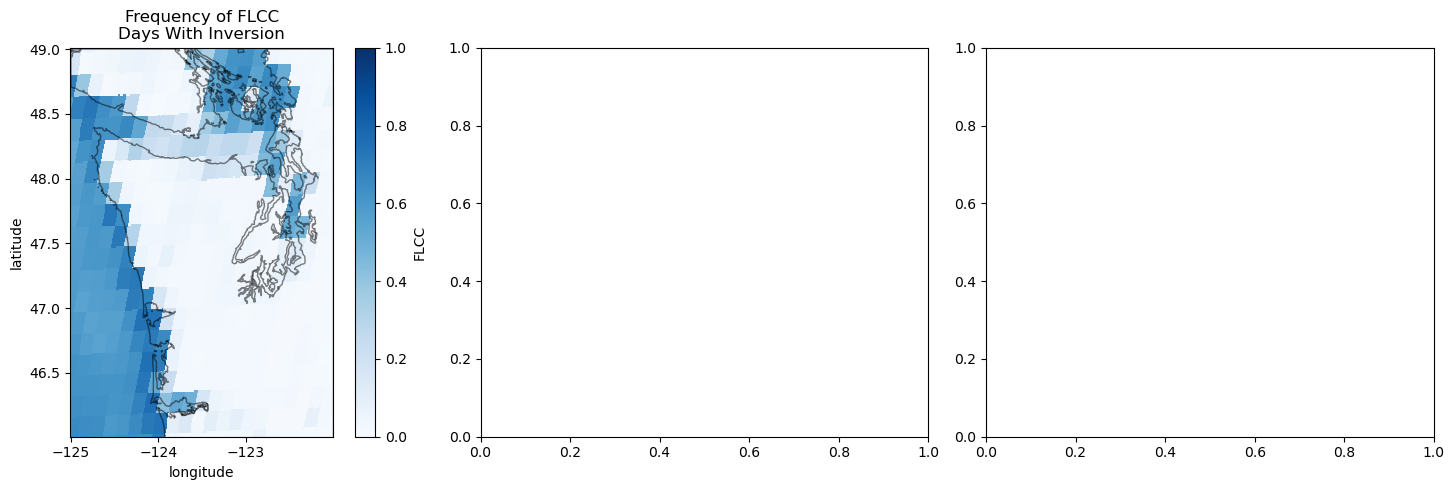

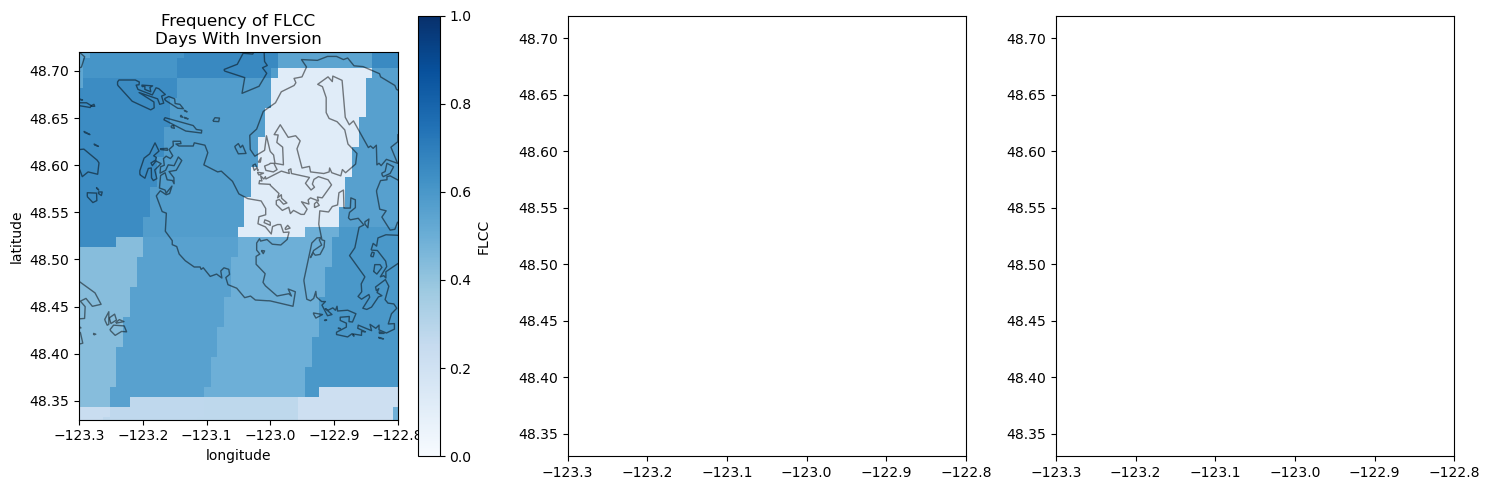

In [91]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5), tight_layout=True)

FLCC_freq_inversion_days.FLCC.plot(ax = ax1, cmap = 'Blues', vmin=0, vmax=1)
shoreline.plot(ax=ax1, edgecolor = "black", color='none', alpha = 0.5, zorder=99)
ax1.set_title('Frequency of FLCC\nDays With Inversion')
plt.savefig('flcc_frequency_maps2.jpg', dpi=300)


fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5), tight_layout=True)

FLCC_freq_inversion_days.FLCC.plot(ax = ax1, cmap = 'Blues', vmin=0, vmax=1)
shoreline.plot(ax=ax1, edgecolor = "black", color='none', alpha = 0.5, zorder=99)
ax1.set_title('Frequency of FLCC\nDays With Inversion')
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_ylim([48.33, 48.72])
    this_ax.set_xlim([-123.3, -122.8])
plt.savefig('flcc_frequency_maps2_zoom.jpg', dpi=300)

get_four_pixel_values(FLCC_freq_inversion_days, 'FLCC')


FHL (north east): 0.37
CP (south east): 0.81
FB (south west): 0.89
MD (north west): 0.84


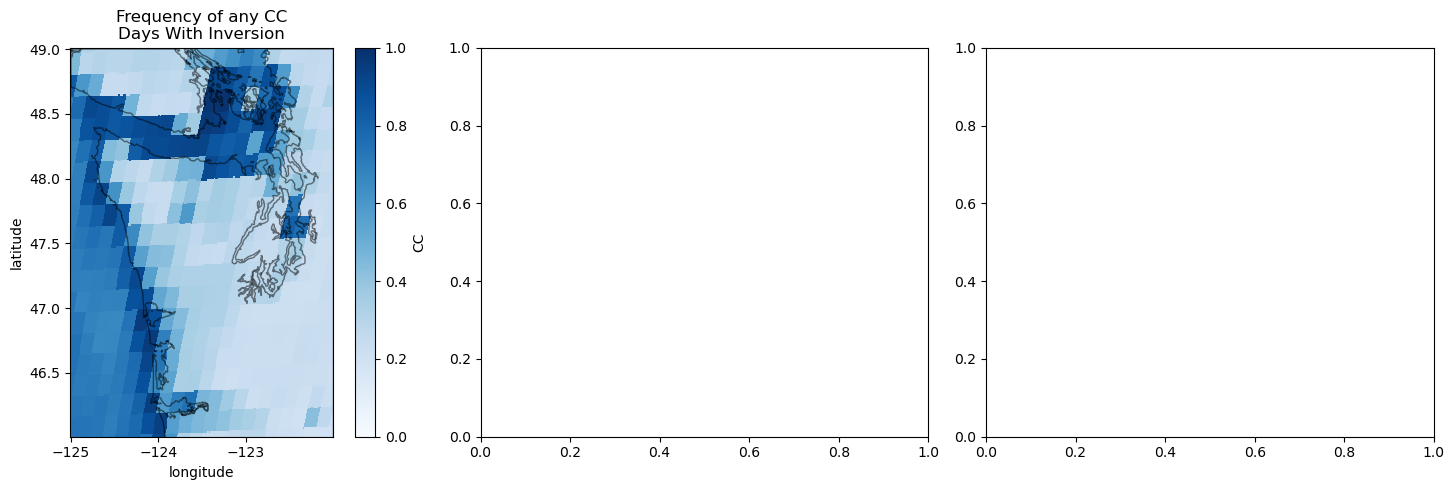

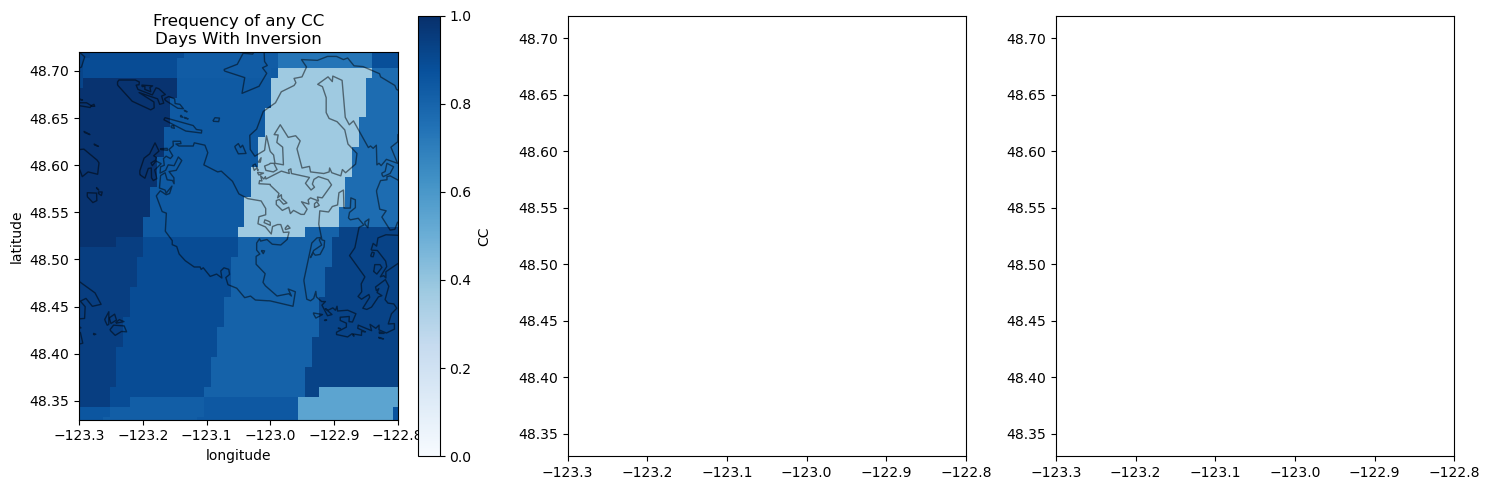

In [89]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5), tight_layout=True)

CC_freq_inversion_days.CC.plot(ax = ax1, cmap = 'Blues', vmin=0, vmax=1)
shoreline.plot(ax=ax1, edgecolor = "black", color='none', alpha = 0.5, zorder=99)
ax1.set_title('Frequency of any CC\nDays With Inversion')
plt.savefig('cc_frequency_maps2.jpg', dpi=300)


fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5), tight_layout=True)

CC_freq_inversion_days.CC.plot(ax = ax1, cmap = 'Blues', vmin=0, vmax=1)
shoreline.plot(ax=ax1, edgecolor = "black", color='none', alpha = 0.5, zorder=99)
ax1.set_title('Frequency of any CC\nDays With Inversion')
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_ylim([48.33, 48.72])
    this_ax.set_xlim([-123.3, -122.8])
plt.savefig('cc_frequency_maps2_zoom.jpg', dpi=300)

get_four_pixel_values(CC_freq_inversion_days, 'CC')